2017.07.31 Chainer v2向けに変更を行いました。

# はじめに

[第1回 Chainer Beginner's Hands-on](https://chainer.connpass.com/event/53429/)を大手町にあるPreferred Networksオフィスの多目的室にて開催いたしました。この記事は、このハンズオンで行った内容を記事化したものです。

ハンズオン当日に使用した資料等は以下のGithubリポジトリにまとめられています：[mitmul/chainer-handson](https://github.com/mitmul/chainer-handson)

## 環境構築について

当日は、さくらインターネット様より4つのPascal TITAN Xが搭載されたGPUサーバを20台（合計80GPUs！）、無償にてお借りし、参加者の皆様に使って頂く形でハンズオンを行いました。この場をお借りしてさくらインターネット様に感謝申し上げます。さくら高火力コンピューティングでは、近日、時間単位でのGPUサーバのレンタルサービスが開始されるとのことですので、GPU環境の導入をご検討の方は、ぜひチェックしてみてください。

[さくら高火力コンピューティング](https://www.sakura.ad.jp/koukaryoku/)

ハンズオン当日はまず、このお借りしたさくら高火力の各ノードにsshログインしていただき、NVIDIA CUDAをインストールするところから始めましたが、この記事ではその部分はスキップし、Chainerの使い方に関する部分からまとめていきます。

環境構築の方法については、以下の資料にまとめてありますので、ご参照ください。

[さくら高火力コンピューティングサーバ上での環境構築](http://bit.ly/chainer-handson-vol1)

これは一部を除けばUbuntu 14.04で動いているNVIDIA GPUが搭載されたサーバに対する環境構築の手順としてお使い頂けます。

それでは本題に入っていきます。以下は、Ubuntu14.04に標準でインストールされているPython 3.4を前提として書かれたチュートリアルになっています。あらかじめ上記資料のP.9、P.11あたりを参考に、関連ライブラリとChainer自体のインストールは済ませてください。


## 注意

**以下のコード部分とそれに続く出力結果は、Jupyter notebook上で実行した場合を想定したものとなっています。**

# 学習ループを書いてみよう

ここでは、

1. データセットからデータを取り出す
2. モデルに入力する
3. Optimizerを使ってモデルのパラメータを更新して学習を行うループを回す

ことをやってみます。これらを通して、基本的な学習ループの書き方が体験できます。（ChainerにはTrainerという便利な学習ループの抽象化クラスが用意されていますが、この章はそれを敢えて用いずに解説したものになります。）

## 1. データセットの準備

ここでは、Chainerが用意しているMNISTデータセットを使うための便利なメソッドを利用します。これを使うと、データのダウンロードから、一つ一つのデータを取り出せるようにするところまでが隠蔽されます。

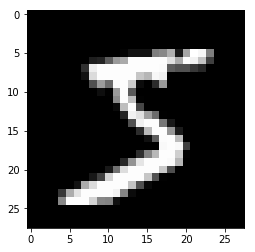

label: 5


In [1]:
from chainer.datasets import mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train, test = mnist.get_mnist(withlabel=True, ndim=1)

# matplotlibを使ったグラフ描画結果がnotebook内に表示されるようにします。
%matplotlib inline
import matplotlib.pyplot as plt

# データの例示
x, t = train[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

## 2. Iteratorの作成

データセットから決まった数のデータを取得し、それらを束ねてミニバッチを作成して返してくれる`Iterator`を作成しましょう。これをこの後の学習ループの中で使用していきます。イテレータは、`next()`メソッドで新しいミニバッチを返してくれます。内部ではデータセットを何周なめたか（`epoch`）、現在のイテレーションが新しいepochの最初のイテレーションか、を管理するプロパティ（`is_new_epoch`）などを持っています。

In [2]:
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize,
                                     repeat=False, shuffle=False)

### Iteratorについて

- Chainerがいくつか用意しているIteratorの一種である`SerialIterator`は、データセットの中のデータを順番に取り出してくる最もシンプルなIteratorです。
- 引数にデータセットオブジェクトと、バッチサイズを取ります。
- このとき渡したデータセットオブジェクトから、何周も何周もデータを繰り返し読み出す必要がある場合は`repeat`引数を`True`とし、1周が終わったらそれ以上データを取り出したくない場合はこれを`False`とします。デフォルトでは、`True`になっています。
- `shuffle`引数に`True`を渡すと、データセットから取り出されてくるデータの順番をエポックごとにランダムに変更します。

ここで、`batchsize = 128`としているので、ここで作成した訓練データ用の`Iterator`である`train_iter`およびテストデータ用の`Iterator`である`test_iter`は、それぞれ128枚の数字画像データを一括りにして返す`Iterator`ということになります。[^TrainingデータとValidationデータ]

## 3. モデルの定義

ここでは、シンプルな三層パーセプトロンを定義します。これは全結合層のみからなるネットワークです。中間層のユニット数は適当に100とし、出力は10クラスなので10とします。ここで用いるMNISTデータセットは10種のラベルを持つためです。では、モデルを定義するために必要な`Link`, `Function`, そして`Chain`について、簡単にここで説明を行います。

### LinkとFunction

- Chainerでは、ニューラルネットワークの各層を、`Link`と`Function`に区別します。
- **`Link`は、パラメータを持つ関数です。**
- **`Function`は、パラメータを持たない関数です。**
- これらを組み合わせてモデルを記述します。
- パラメータを持つ層は、`chainer.links`モジュール以下にたくさん用意されています。
- パラメータを持たない層は、`chainer.functions`モジュール以下にたくさん用意されています。
- これらを簡単に使うために、

In [3]:
import chainer.links as L
import chainer.functions as F

と別名を与えて、`L.Convolution2D(...)`や`F.relu(...)`のように用いる慣習があります。

### Chain

- Chainは、パラメータを持つ層＝**`Link`をまとめておくためのクラス**です。
- パラメータを持つということは、基本的にモデルの学習の際にそれらを更新していく必要があるということです（例外はあります）。
- そこで、学習中に`Optimizer`が更新すべき全てのパラメータを簡単に取得できるように、`Chain`で一箇所にまとめておきます。

### Chainを継承して定義されるモデル

- モデルは`Chain`クラスを継承したクラスとして定義されることが多いです。
- その場合、モデルを表すクラスのコンストラクタで、`with self.init_scope():`のようにして作られたスコープを作り、その中で登録したいリンクオブジェクトをプロパティとして定義しておきます。
- また、関数呼び出しのようにしてモデルに`()`アクセサでデータを渡せるように、`__call__`メソッドを定義して、その中にforward処理を記述すると便利です。

### GPUで実行するには

- `Chain`クラスは`to_gpu`メソッドを持ち、この引数にGPU IDを指定すると、指定したGPU IDのメモリ上にモデルの全パラメータを転送します。
- これはモデル内部でのforward/backward計算をその指定したGPU上で行うために必要になります。
- これを行わない場合、それらの処理はCPU上で行われます。

---

それでは、モデルを定義していきます。まずは乱数シードを固定して、本記事とほぼ同様の結果が再現できるようにしておきましょう。（より厳密に計算結果の再現性を保証したい場合は、`deterministic`というオプションについて知る必要があります。こちらの記事が役に立ちます：[ChainerでGPUを使うと毎回結果が変わる理由と対策](http://qiita.com/TokyoMickey/items/cc8cd43545f2656b1cbd)。

In [4]:
import numpy
numpy.random.seed(0)
import chainer
if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(0)

それでは実際にモデルの定義を行い、オブジェクトを作って、GPUに送信してみましょう。

In [5]:
import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        # パラメータを持つ層の登録
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)

    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = 0  # CPUで処理を行いたい場合は、-1をセットしてください。

model = MLP()
if gpu_id >= 0:
    model.to_gpu(gpu_id)

### NOTE

ここで、`L.Linear`クラスは全結合層を意味します。コンストラクタの第一引数に`None`を渡すと、実行時に、データがその層に入力された瞬間、必要な数の入力側ユニット数を自動的に計算し、`(n_input)` $\times$ `n_mid_units`の大きさの行列を作成し、パラメータとして保持します。これは後々、畳み込み層を全結合層の前に配置する際などに便利な機能です。

前述のように、`Link`はパラメータを持つので、そのパラメータの値にアクセスすることができます。例えば、上のモデル`MLP`は`l1`という名前の全結合層が登録されています。この全結合相は`W`と`b`という2つのパラメータを持ちます。これらは外からアクセスすることができます。例えば`b`へアクセスするには、以下のようにします。

In [6]:
print('1つ目の全結合相のバイアスパラメータの形は、', model.l1.b.shape)
print('初期化直後のその値は、', model.l1.b.data)

1つ目の全結合相のバイアスパラメータの形は、 (100,)
初期化直後のその値は、 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


ここで、`model.l1.W`を`print`してみると、まだ初期化されておらず何も値が入っていないことがわかります。

In [7]:
print(model.l1.W)

variable W(None)


これは、上記モデルの定義では`Linear`リンクのコンストラクタの第一引数に`None`を渡したため、実行時まで行列`W`は確保されないからです。存在してはいないが、存在する予定であることは`Linear`オブジェクトの内部で把握されています。

## 4. 最適化手法の選択

Chainerは多くの最適化手法を提供しています。`chainer.optimizers`モジュール以下にそれらはあります。ここでは最もシンプルな勾配降下法の手法である`optimizers.SGD`を用います。Optimizerのオブジェクトには、`setup`メソッドを使ってモデル（`Chain`オブジェクト）を渡します。こうすることでOptimizerは、自身が更新すべきモデル内のパラメータを自動的にたどってくれます。

他にもいろいろな最適化手法が手軽に試せるので、色々と試してみて結果の変化を見てみてください。例えば、下の`chainer.optimizers.SGD`のうち`SGD`の部分を`MomentumSGD`, `RMSprop`,  `Adam`などに変えて、結果の違いを見てみると良いでしょう。

In [8]:
from chainer import optimizers

optimizer = optimizers.SGD(lr=0.01)
optimizer.setup(model)

### NOTE

今回はSGDのコンストラクタの`lr`という引数に $0.01$ を与えました。この値は学習率として知られ、モデルをうまく訓練して良いパフォーマンスを発揮させるために調整する必要がある重要な**ハイパーパラメータ**として知られています。

## 5. 学習ループ

いよいよ学習ループです。今回は分類問題なので、`softmax_cross_entropy`というロス関数を使って最小化すべきロスの値を計算します。

Chainerでは、`Function`や`Link`を使ってモデルのforward計算を行い、結果と正解ラベルを`Function`の一種でありスカラ値を返すロス関数に渡してやり、ロスの計算を行うと、それは他の`Link`や`Function`と同じく、`Variable`オブジェクトを返します。`Variable`オブジェクトはこれまでの計算過程をあとから逆向きに辿り返すための参照を保持しているため、`Variable.backward()`メソッドを呼ぶだけで、自動的にそこからこれまでの計算過程を遡って、途中で施された計算に用いられたパラメータの勾配を計算してくれます。

つまり、学習ループの1回の中で行うのは、以下の4項目です。

1. モデルにデータを渡して出力`y`を得る
2. `y`と正解ラベル`t`を使って、最小化すべきロスの値を`softmax_cross_entropy`関数で計算する
3. `softmax_cross_entropy`関数の出力`Variable`の`backward`メソッドを呼んで、モデル内部のパラメータに`grad`プロパティ（これがパラメータ更新に使われる勾配）を持たせる
4. Optimizerの`update`メソッドを呼び、3.で計算した`grad`を使って全パラメータを更新する

以上です。分類問題ではなく、例えば簡単な回帰問題に取り組むような場合、`F.softmax_cross_entropy`の代わりに`F.mean_squared_error`などを用いることもできます。他にも、いろいろな問題設定に対応するために様々なロス関数がChainerには用意されています。こちらからその一覧を見ることができます：[Loss functions](http://docs.chainer.org/en/latest/reference/functions.html#loss-functions)。

では、さっそく訓練ループを書いていきます。

In [9]:
import numpy as np
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

max_epoch = 10

while train_iter.epoch < max_epoch:

    # ---------- 学習の1イテレーション ----------
    train_batch = train_iter.next()
    x, t = concat_examples(train_batch, gpu_id)

    # 予測値の計算
    y = model(x)

    # ロスの計算
    loss = F.softmax_cross_entropy(y, t)

    # 勾配の計算
    model.cleargrads()
    loss.backward()

    # パラメータの更新
    optimizer.update()
    # --------------- ここまで ----------------

    # 1エポック終了ごとにValidationデータに対する予測精度を測って、
    # モデルの汎化性能が向上していることをチェックしよう
    if train_iter.is_new_epoch:  # 1 epochが終わったら

        # 評価モードにするために、trainコンフィグをFalseにします
        with chainer.using_config('train', False):
            # ロスの表示
            print('epoch:{:02d} train_loss:{:.04f} '.format(
                train_iter.epoch, float(to_cpu(loss.data))), end='')

            test_losses = []
            test_accuracies = []
            while True:
                test_batch = test_iter.next()
                x_test, t_test = concat_examples(test_batch, gpu_id)

                # テストデータをforward
                y_test = model(x_test)

                # ロスを計算
                loss_test = F.softmax_cross_entropy(y_test, t_test)
                test_losses.append(to_cpu(loss_test.data))

                # 精度を計算
                accuracy = F.accuracy(y_test, t_test)
                accuracy.to_cpu()
                test_accuracies.append(accuracy.data)

                if test_iter.is_new_epoch:
                    test_iter.reset()
                    break

            print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
                np.mean(test_losses), np.mean(test_accuracies)))

epoch:01 train_loss:0.8068 val_loss:0.7973 val_accuracy:0.8343
epoch:02 train_loss:0.4726 val_loss:0.4634 val_accuracy:0.8790
epoch:03 train_loss:0.4178 val_loss:0.3770 val_accuracy:0.8981
epoch:04 train_loss:0.5055 val_loss:0.3382 val_accuracy:0.9062
epoch:05 train_loss:0.2944 val_loss:0.3127 val_accuracy:0.9126
epoch:06 train_loss:0.3196 val_loss:0.2960 val_accuracy:0.9158
epoch:07 train_loss:0.2762 val_loss:0.2832 val_accuracy:0.9195
epoch:08 train_loss:0.1826 val_loss:0.2712 val_accuracy:0.9222
epoch:09 train_loss:0.2518 val_loss:0.2612 val_accuracy:0.9251
epoch:10 train_loss:0.1884 val_loss:0.2521 val_accuracy:0.9277


`val_accuracy`に着目してみると、最終的に10エポックで $0.9286$ になっています。おおよそ93%程度の精度で手書きの数字が分類できるようになりました。

## 6. 学習済みモデルを保存する

Chainerには2つのシリアライズ機能が用意されています。一つはHDF5形式でモデルを保存するもので、もう一つはNumPyのNPZ形式でモデルを保存するものです。今回は、追加ライブラリのインストールが必要なHDF5ではなく、NumPy標準機能で提供されているシリアライズ機能を利用したNPZ形式でのモデルの保存を行います。

In [10]:
from chainer import serializers

serializers.save_npz('my_mnist.model', model)

# ちゃんと保存されていることを確認
%ls -la my_mnist.model

-rw-rw-r-- 1 shunta shunta 333884 Jul 31 23:24 my_mnist.model


## 7. 保存したモデルを読み込んで推論する

今しがた保存したNPZファイルを読み込んで、テストデータに対するラベルの予測をネットワークに行わせてみます。NPZファイルにはパラメータが保存されているので、forward計算のロジックを持つモデルのオブジェクトをまず作成し、そのパラメータを先程保存したNPZが持つ値で上書きすることで学習直後のモデルの状態を復元します。

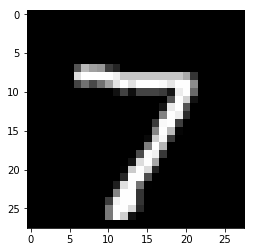

label: 7


In [11]:
# まず同じモデルのオブジェクトを作る
model = MLP()

# そのオブジェクトに保存済みパラメータをロードする
serializers.load_npz('my_mnist.model', model)

# GPU上で計算させるために、モデルをGPUに送る
if gpu_id >= 0:
    model.to_gpu(gpu_id)

# テストデータ
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

これからモデルに推論させることになるテストデータを表示してみました。以下がこの画像に対し推論を行わせる例になります。

In [12]:
from chainer.cuda import to_gpu

# ミニバッチの形にする（ここではサイズ1のミニバッチにするが、
# 複数まとめてサイズnのミニバッチにしてまとめて推論することもできる）
print(x.shape, end=' -> ')
x = x[None, ...]
print(x.shape)

# GPU上で計算させるため、データもGPU上に送る
if gpu_id >= 0:
    x = to_gpu(x, gpu_id)

# モデルのforward関数に渡す
with chainer.using_config('train', False):
    y = model(x)

# Variable形式で出てくるので中身を取り出す
y = y.data

# 結果をCPUに送る
y = to_cpu(y)

# 最大値のインデックスを見る
pred_label = y.argmax(axis=1)

print('predicted label:', pred_label[0])

(784,) -> (1, 784)
predicted label: 7


# Trainerを使ってみよう

Trainerを使うと学習ループを陽に書く必要がなくなります。またいろいろな便利なExtentionを使うことで可視化やログの保存などが楽になります。

## 1. データセットの準備

In [13]:
from chainer.datasets import mnist

train, test = mnist.get_mnist()

## 2. Iteratorの準備

In [14]:
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

## 3. Modelの準備

ここでは、先程と同じモデルを再度用いますので、定義は省略します。

In [15]:
model = MLP()

## 4. Updaterの準備

Trainerは学習に必要な全てのものをひとまとめにするクラスです。Trainerと、それが内部に持つユーティリティクラスやモデル、データセットクラスなどは、以下のような関係になっています。

![image](https://qiita-image-store.s3.amazonaws.com/0/17934/a751df31-b999-f692-d839-488c26b1c48a.png)

`Trainer`オブジェクトを作成するときに渡すのは基本的に`Updater`だけですが、`Updater`は中に`Iterator`と`Optimizer`を持っています。`Iterator`からはデータセットにアクセスすることができ、`Optimizer`は中でモデルへの参照を保持しているので、モデルのパラメータを更新することができます。つまり、`Updater`が内部で

1. データセットからデータを取り出し（Iterator）
2. モデルに渡してロスを計算し（Model = Optimizer.target）
3. Optimizerを使ってモデルのパラメータを更新する（Optimizer）

という一連の学習の主要部分を行うことができるということです。では、`Updater`オブジェクトを作成してみます。

In [16]:
from chainer import optimizers
from chainer import training

max_epoch = 20
gpu_id = 0  # CPUを用いる場合は、-1をセットしてください

# モデルをClassifierで包んで、ロスの計算などをモデルに含める
model = L.Classifier(model)
if gpu_id >= 0:
    model.to_gpu(gpu_id)

# 最適化手法の選択
optimizer = optimizers.SGD(lr=0.1)
optimizer.setup(model)

# UpdaterにIteratorとOptimizerを渡す
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

### NOTE

ここで、上で定義したモデルのオブジェクトを`L.Classifier`に渡して、新しい`Chain`にしています。`L.Classifier`は`Chain`を継承したクラスで、渡された`Chain`を`predictor`というプロパティに保存します。`()`アクセサでデータとラベルを渡すと、中で`__call__`が実行され、まず渡されたデータの方を`predictor`に通し、その出力`y`と、データと一緒に`__call__`に渡されていたラベルを、コンストラクタの`lossfun`引数で指定されたロス関数に渡して、その出力`Variable`を返します。`lossfun`はデフォルトで`softmax_cross_entropy`に指定されています。

`StandardUpdater`は前述のようなUpdaterの担当する処理を遂行するための最もシンプルなクラスです。この他にも複数のGPUを用いるための`ParallelUpdater`などが用意されています。

## 5. Trainerの設定

最後に、`Trainer`の設定を行います。`Trainer`のオブジェクトを作成する際に必須となるのは、先程作成した`Updater`オブジェクトだけですが、二番目の引数`stop_trigger`に学習をどのタイミングで終了するかを表す`(長さ, 単位)`という形のタプルを与えると、指定したタイミングで学習を自動的に終了することができます。長さには任意の整数、単位には`'epoch'`か`'iteration'`のいずれかの文字列を指定できます。`stop_trigger`を指定しない場合、学習は自動的には止まりません。

In [17]:
# TrainerにUpdaterを渡す
trainer = training.Trainer(updater, (max_epoch, 'epoch'),
                           out='mnist_result')

`out`引数では、この次に説明する`Extension`を使って、ログファイルやロスの変化の過程を描画したグラフの画像ファイルなどを保存するディレクトリを指定しています。

## 6. TrainerにExtensionを追加する

`Trainer`を使う利点として、

- ログを自動的にファイルに保存（`LogReport`)
- ターミナルに定期的にロスなどの情報を表示（`PrintReport`）
- ロスを定期的にグラフで可視化して画像として保存（`PlotReport`)
- 定期的にモデルやOptimizerの状態を自動シリアライズ（`snapshot`/`snapshot_object`）
- 学習の進捗を示すプログレスバーを表示（`ProgressBar`）
- モデルの構造をGraphvizのdot形式で保存（`dump_graph`）

などなどの様々な便利な機能を簡単に利用することができる点があります。これらの機能を利用するには、`Trainer`オブジェクトに対して`extend`メソッドを使って追加したい`Extension`のオブジェクトを渡してやるだけです。では実際に幾つかの`Extension`を追加してみましょう。

In [18]:
from chainer.training import extensions

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

### `LogReport`

`epoch`や`iteration`ごとの`loss`, `accuracy`などを自動的に集計し、`Trainer`の`out`引数で指定した出力ディレクトリに`log`というファイル名で保存します。

### `snapshot`

`Trainer`の`out`引数で指定した出力ディレクトリに`Trainer`オブジェクトを指定されたタイミング（デフォルトでは1エポックごと）に保存します。`Trainer`オブジェクトは上述のように`Updater`を持っており、この中に`Optimizer`とモデルが保持されているため、この`Extension`でスナップショットをとっておけば、学習の復帰や学習済みモデルを使った推論などが学習終了後にも可能になります。

### `snapshot_object`

しかし、`Trainer`ごと保存した場合、しばしば中身のモデルだけ取り出すのが面倒な場合があります。そこで、`snapshot_object`を使って指定したオブジェクト（ここでは`Classifier`で包まれたモデル）だけを、`Trainer`とは別に保存するようにします。`Classifier`は第1引数に渡された`Chain`オブジェクトを自身の`predictor`というプロパティとして保持してロスの計算を行う`Chain`であり、`Classifier`はそもそもモデル以外にパラメータを持たないので、ここでは後々学習済みモデルを推論に使うことを見越して`model.predictor`を保存対象として指定しています。

### `dump_graph`

指定された`Variable`オブジェクトから辿れる計算グラフをGraphvizのdot形式で保存します。保存先は`Trainer`の`out`引数で指定した出力ディレクトリです。

### `Evaluator`

評価用のデータセットの`Iterator`と、学習に使うモデルのオブジェクトを渡しておくことで、学習中のモデルを指定されたタイミングで評価用データセットを用いて評価します。

### `PrintReport`

`Reporter`によって集計された値を標準出力に出力します。このときどの値を出力するかを、リストの形で与えます。

### `PlotReport`

引数のリストで指定された値の変遷を`matplotlib`ライブラリを使ってグラフに描画し、出力ディレクトリに`file_name`引数で指定されたファイル名で画像として保存します。

---

これらの`Extension`は、ここで紹介した以外にも、例えば`trigger`によって個別に作動するタイミングを指定できるなどのいくつかのオプションを持っており、より柔軟に組み合わせることができます。詳しくは公式のドキュメントを見てください：[Trainer extensions](http://docs.chainer.org/en/latest/reference/extensions.html)。

## 7. 学習を開始する

学習を開始するには、`Trainer`オブジェクトのメソッド`run`を呼ぶだけです。

In [19]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.499081    0.861024       0.252833              0.924545                  1.94617       
2           0.23073     0.933202       0.180059              0.947686                  4.33679       
3           0.17229     0.95016        0.152644              0.955696                  6.92889       
4           0.138831    0.959736       0.120657              0.964794                  9.38878       
5           0.116327    0.965952       0.10962               0.967168                  11.8244       
6           0.0987802   0.971215       0.100377              0.968849                  14.3496       
7           0.0873225   0.974347       0.0907917             0.972706                  16.9415       
8           0.0765652   0.977981       0.087784              0.973991                  19.3647       
9           0.0684015   0.980011       0.0801619             0.975277               

初めに取り組んだ学習ループを自分で書いた場合よりもより短いコードで、リッチなログ情報とともに、下記で表示してみるようなグラフなども作りつつ、同様の結果を得ることができました。

さっそく保存されているロスのグラフを確認してみましょう。

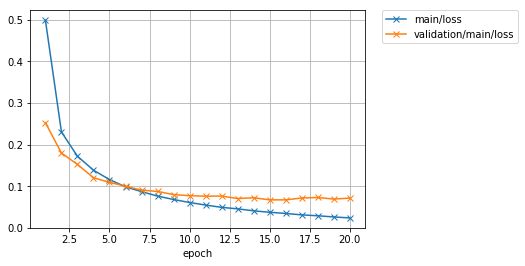

In [20]:
from IPython.display import Image
Image(filename='mnist_result/loss.png')

精度のグラフも見てみましょう。

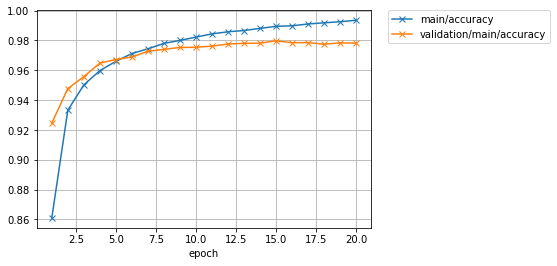

In [21]:
Image(filename='mnist_result/accuracy.png')

もう少し学習を続ければ、まだ多少精度の向上が図れそうな雰囲気がありますね。

ついでに、`dump_graph`という`Extension`が出力した計算グラフを、`Graphviz`を使って画像化して見てみましょう。

In [22]:
%%bash
dot -Tpng mnist_result/cg.dot -o mnist_result/cg.png

ここではJupyter notebook上でbashコマンドを使うCell magicを使用しています。2行目のコマンド自体は通常のシェルコマンドです。

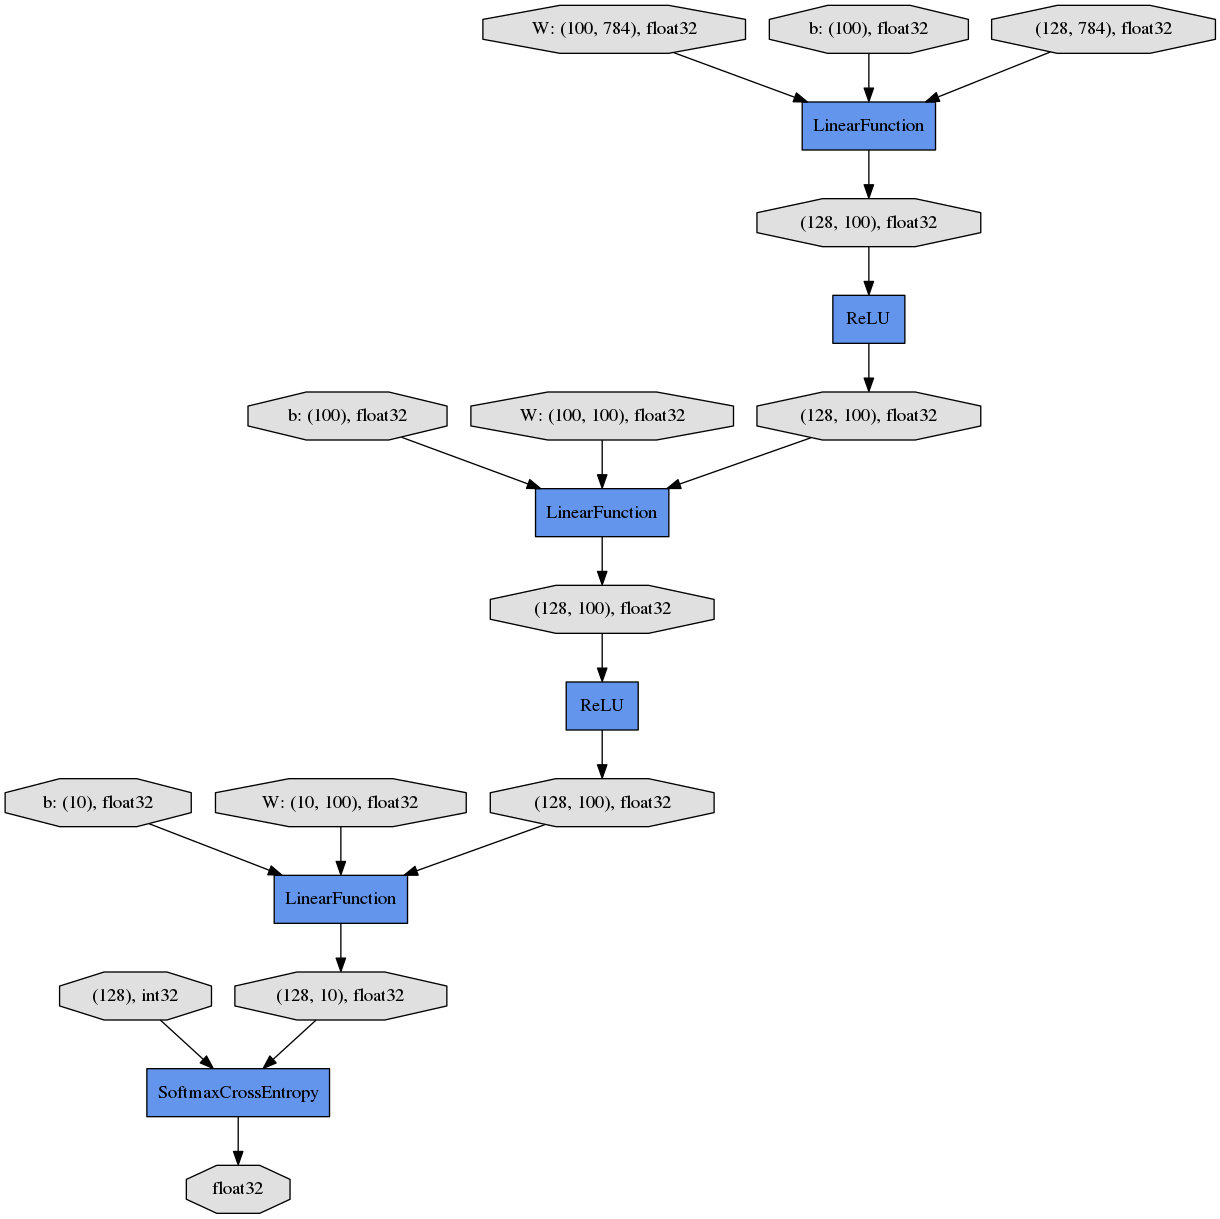

In [23]:
Image(filename='mnist_result/cg.png')

上から下へ向かって、データやパラメータがどのような`Function`に渡されて計算が行われ、ロスを表す`Variable`が出力されたかが分かります。

## 8. 学習済みモデルで推論する

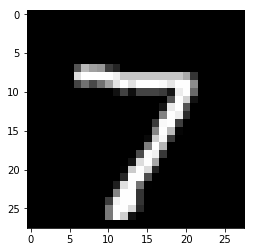

label: 7
predicted_label: 7


In [24]:
import numpy as np
from chainer import serializers
from chainer.cuda import to_gpu
from chainer.cuda import to_cpu

model = MLP()
serializers.load_npz('mnist_result/model_epoch-10', model)
if gpu_id >= 0:
    model.to_gpu(gpu_id)

x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

x = x[None, ...]
x = to_gpu(x, gpu_id) if gpu_id >= 0 else x
with chainer.using_config('train', False):
    y = model(x)
y = to_cpu(y.data)

print('predicted_label:', y.argmax(axis=1)[0])

無事正解できました。

# 新しいネットワークを書いてみよう

次に、MNISTデータセットではなくCIFAR10という32x32サイズの小さなカラー画像に10クラスのいずれかのラベルがついたデータセットを用いて、いろいろなモデルを自分で書いて試行錯誤する流れを体験してみます。

| airplane | automobile | bird | cat | deer | dog | frog | horse | ship | truck |
|:--------:|:----------:|:----:|:---:|:----:|:---:|:----:|:-----:|:----:|:-----:|
| ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck4.png) |

## 1. モデルの定義

モデルは、`Chain`クラスを継承して定義します。ここでは、さきほど試した全結合層だけからなるネットワークではなく、畳込み層を持つネットワークを定義してみます。このモデルは3つの畳み込み層を持ち、2つの全結合層がそのあとに続いています。

モデルの定義は主に2つのメソッドの定義によって行います。

1. `__init__`コンストラクタでモデルを構成するレイヤーを定義する
    - この際、親クラス（`Chain`）のコンストラクタに`super`を用いてキーワード引数としてモデルを構成する`Link`オブジェクトを渡すことで`Optimizer`から捕捉可能な最適化対象のパラメータを持つレイヤをモデルに追加することができます。
2. データを受け取る`()`アクセサで呼ばれる`__call__`メソッドに、Forward計算を記述する

In [25]:
import chainer
import chainer.functions as F
import chainer.links as L

class MyModel(chainer.Chain):

    def __init__(self, n_out):
        super(MyModel, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 6, 5, 1)
            self.conv2 = L.Convolution2D(6, 16, 5, 1)
            self.conv3 = L.Convolution2D(16, 120, 4, 1)
            self.fc4 = L.Linear(None, 84)
            self.fc5 = L.Linear(84, n_out)

    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.fc4(h))
        h = self.fc5(h)
        return h

## 2. 学習

ここで、あとから別のモデルも簡単に同じ設定で訓練できるよう、`train`関数を定義しておきます。これは、

- モデルのオブジェクト
- バッチサイズ
- 使用するGPU ID
- 学習を終了するエポック数
- データセットオブジェクト

を渡すと、内部で`Trainer`を用いて渡されたデータセットを使ってモデルを訓練し、学習が終了した状態のモデルを返してくれる関数です。

この`train`関数を用いて、上で定義した`MyModel`モデルを訓練してみます。

In [26]:
from chainer.datasets import cifar
from chainer import iterators
from chainer import optimizers
from chainer import training
from chainer.training import extensions

def train(model_object, batchsize=64, gpu_id=0,
          max_epoch=20, train_dataset=None, test_dataset=None):

    # 1. Dataset
    if train_dataset is None and test_dataset is None:
        train, test = cifar.get_cifar10()
    else:
        train, test = train_dataset, test_dataset

    # 2. Iterator
    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    # 3. Model
    model = L.Classifier(model_object)
    if gpu_id >= 0:
        model.to_gpu(gpu_id)

    # 4. Optimizer
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    # 5. Updater
    updater = training.StandardUpdater(
        train_iter, optimizer, device=gpu_id)

    # 6. Trainer
    trainer = training.Trainer(
        updater, (max_epoch, 'epoch'),
        out='{}_cifar10_result'.format(model_object.__class__.__name__))

    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.run()
    del trainer

    return model

model = train(MyModel(10), gpu_id=0)  # CPUで実行する場合は、`gpu_id=-1`を指定して下さい。

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.60486     0.419557       1.39821               0.502289                  5.4494        
2           1.29682     0.538372       1.28784               0.540705                  11.1927       
3           1.16459     0.586688       1.20128               0.57504                   17.0035       
4           1.05643     0.629401       1.1574                0.58957                   22.7169       
5           0.959835    0.661425       1.1393                0.597233                  28.4726       
6           0.864292    0.696063       1.13649               0.620024                  34.1849       
7           0.775904    0.726573       1.22777               0.600916                  40.0822       
8           0.682157    0.760363       1.27081               0.601513                  45.9055       
9           0.601456    0.786485       1.30436               0.602209               

学習が20エポックまで終わりました。ロスと精度のプロットを見てみましょう。

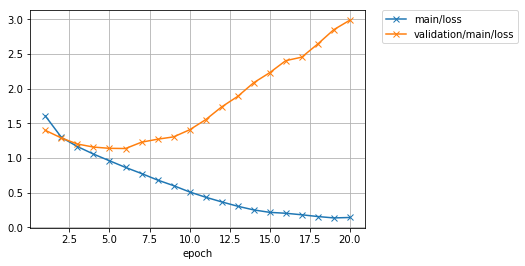

In [27]:
Image(filename='MyModel_cifar10_result/loss.png')

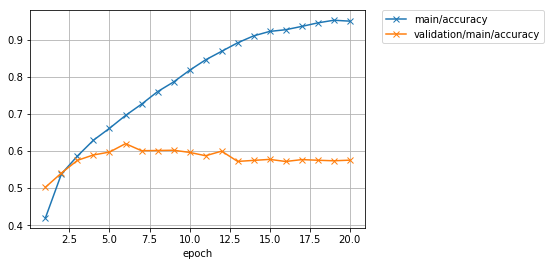

In [28]:
Image(filename='MyModel_cifar10_result/accuracy.png')

学習データでの精度（`main/accuracy`)は95%付近まで到達していますが、検証データでの精度（`validation/main/accuracy`）は一度60%程度に到達したあとは、下がっていってしまっています。検証データでのロス（`validation/main/loss`）を見ると、5エポック後以降はどんどん大きくなっていっていることが分かります。学習データでは良い精度が出ているが、検証データでは精度が良くないという場合、**モデルが学習データにオーバーフィッティングしている**ことが考えられます。

## 3. 学習済みモデルを使った予測

テスト精度は60%弱でしたが、試しにこの学習済みモデルを使っていくつかのテスト画像を分類させてみましょう。

predicted_label: airplane
answer: airplane


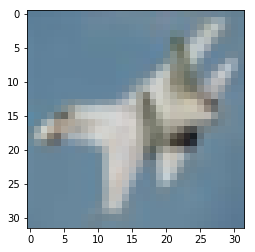

predicted_label: truck
answer: truck


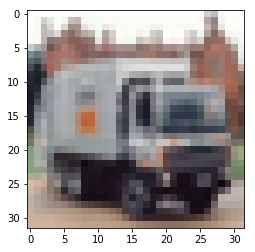

predicted_label: bird
answer: dog


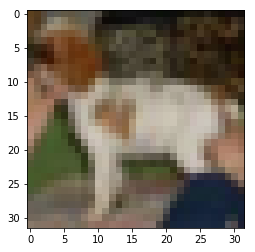

predicted_label: horse
answer: horse


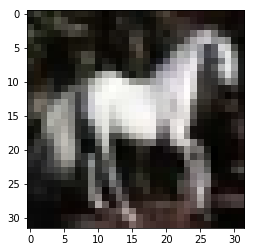

predicted_label: truck
answer: truck


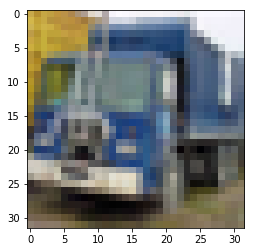

In [29]:
cls_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
             'dog', 'frog', 'horse', 'ship', 'truck']

def predict(model, image_id):
    _, test = cifar.get_cifar10()
    x, t = test[image_id]
    model.to_cpu()
    with chainer.using_config('train', False):
        y = model.predictor(x[None, ...]).data.argmax(axis=1)[0]
    print('predicted_label:', cls_names[y])
    print('answer:', cls_names[t])

    plt.imshow(x.transpose(1, 2, 0))
    plt.show()

for i in range(10, 15):
    predict(model, i)

分類に失敗しているものがいくつも見られます。モデルの学習に使用したデータセット上ではほぼ百発百中で正解できるとしても、未知のデータ、すなわち検証（or テスト）データセットにある画像に対して高精度な予測ができなければ、意味がありません[^NN]。検証データでの精度は、モデルの**汎化性能**に関係していると言われます。

どうすれば高い汎化性能を持つモデルを設計し、学習することができるでしょうか？

## 4. もっと深いモデルを定義してみよう

では、上のモデルよりもよりたくさんの層を持つモデルを定義してみましょう。ここでは、1層の畳み込みネットワークを`ConvBlock`、1層の全結合ネットワークを`LinearBlock`として定義し、これをたくさんシーケンシャルに積み重ねる方法で大きなネットワークを定義してみます。

### 構成要素を定義する

まず、今目指している大きなネットワークの構成要素となる`ConvBlock`と`LinearBlock`を定義してみましょう。

In [30]:
class ConvBlock(chainer.Chain):

    def __init__(self, n_ch, pool_drop=False):
        w = chainer.initializers.HeNormal()
        super(ConvBlock, self).__init__()
        with self.init_scope():
            self.conv = L.Convolution2D(
                None, n_ch, 3, 1, 1, nobias=True, initialW=w)
            self.bn = L.BatchNormalization(n_ch)
        self.pool_drop = pool_drop

    def __call__(self, x):
        h = F.relu(self.bn(self.conv(x)))
        if self.pool_drop:
            h = F.max_pooling_2d(h, 2, 2)
            h = F.dropout(h, ratio=0.25)
        return h

class LinearBlock(chainer.Chain):

    def __init__(self):
        w = chainer.initializers.HeNormal()
        super(LinearBlock, self).__init__()
        with self.init_scope():
            self.fc = L.Convolution2D(None, 1024, 1, 1, 0, initialW=w)

    def __call__(self, x):
        return F.dropout(F.relu(self.fc(x)), ratio=0.6)

`ConvBlock`は`Chain`を継承したモデルとして定義されています。これは一つの畳み込み層とBatch Normalization層をパラメータありで持っているので、コンストラクタ内でこれらの登録を行っています。`__call__`メソッドでは、これらにデータを渡しつつ、活性化関数ReLUを適用して、さらに`pool_drop`がコンストラクタに`True`で渡されているときはMax PoolingとDropoutという関数を適用するような小さなネットワークになっています。

Chainerでは、Pythonを使って書いたforward計算のコード自体がモデルの構造を表します。すなわち、実行時にデータがどのような層をくぐっていったか、ということがネットワークそのものを定義します。これによって、上記のような分岐などを含むネットワークも簡単に書け、柔軟かつシンプルで可読性の高いネットワーク定義が可能になります。これが**Define-by-Run**と呼ばれる特徴です。

### 大きなネットワークの定義

次に、これらの小さなネットワークを構成要素として積み重ねて、大きなネットワークを定義してみましょう。

In [31]:
class DeepCNN(chainer.ChainList):

    def __init__(self, n_output):
        super(DeepCNN, self).__init__(
            ConvBlock(64),
            ConvBlock(64, True),  # 14
            ConvBlock(128),
            ConvBlock(128, True),  # 7
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(512),
            ConvBlock(512),
            ConvBlock(512),
            LinearBlock(),
            LinearBlock(),
            L.Linear(None, n_output)
        )

    def __call__(self, x):
        for f in self:
            x = f(x)
        return x

ここで利用しているのが、`ChainList`というクラスです。このクラスは`Chain`を継承したクラスで、いくつもの`Link`や`Chain`を順次呼び出していくようなネットワークを定義するときに便利です。`ChainList`を継承して定義されるモデルは、親クラスのコンストラクタを呼び出す際に**キーワード引数ではなく普通の引数として**`Link`もしくは`Chain`オブジェクトを渡すことができます。そしてこれらは、**self.children()**メソッドによって**登録した順番に**取り出すことができます。

この特徴を使うと、forward計算の記述が簡単になります。**self.children()**が返す構成要素のリストから、for文で構成要素を順番に取り出していき、そもそもの入力である`x`に取り出してきた部分ネットワークの計算を適用して、この出力で`x`を置き換えるということを順番に行っていけば、一連の`Link`または`Chain`を、コンストラクタで親クラスに登録した順番と同じ順番で適用していくことができます。そのため、シーケンシャルな部分ネットワークの適用によって表される大きなネットワークを定義するのに重宝します。

それでは、学習を回してみます。今回はパラメータ数も多いので、学習を停止するエポック数を100に設定します。

In [32]:
model = train(DeepCNN(10), max_epoch=50)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.85671     0.334739       1.39725               0.500398                  33.2824       
2           1.19771     0.570122       1.0174                0.644208                  67.1486       
3           0.943586    0.665993       0.818173              0.710191                  101.896       
4           0.779686    0.728133       0.727823              0.753085                  137.454       
5           0.67542     0.765145       0.671378              0.772492                  172.292       
6           0.590576    0.797715       0.645285              0.779956                  207.662       
7           0.527403    0.819462       0.573353              0.80215                   243.242       
8           0.469255    0.838748       0.539177              0.818571                  278.583       
9           0.419556    0.855579       0.498955              0.837381               

学習が終了しました。ロスと精度のグラフを見てみましょう。

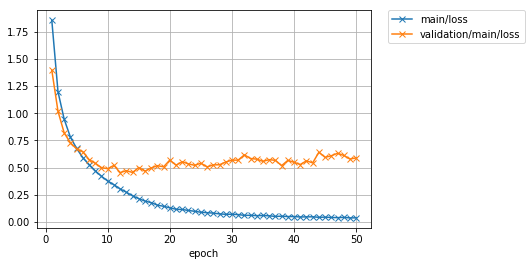

In [33]:
Image(filename='DeepCNN_cifar10_result/loss.png')

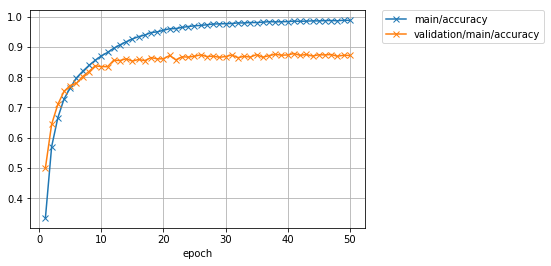

In [34]:
Image(filename='DeepCNN_cifar10_result/accuracy.png')

先程よりも大幅にテストデータに対する精度が向上したことが分かります。62%前後だった精度が、87%程度まで上がりました。しかし最新の研究成果では97%近くまで達成されています。さらに精度を上げるには、今回行ったようなモデルの改良ももちろんのこと、学習データを擬似的に増やす操作（Data augmentation）や、複数のモデルの出力を一つの出力に統合する操作（Ensemble）などなど、いろいろな工夫が考えられます。

# データセットクラスを書いてみよう

ここでは、Chainerにすでに用意されているCIFAR10のデータを取得する機能を使って、データセットクラスを自分で書いてみます。Chainerでは、データセットを表すクラスは以下の機能を持っていることが必要とされます。

- データセット内のデータ数を返す`__len__`メソッド
- 引数として渡される`i`に対応したデータもしくはデータとラベルの組を返す`get_example`メソッド

その他のデータセットに必要な機能は、`chainer.dataset.DatasetMixin`クラスを継承することで用意できます。ここでは、`DatasetMixin`クラスを継承し、Data augmentation機能のついたデータセットクラスを作成してみましょう。

## 1. CIFAR10データセットクラスを書く

In [35]:
import numpy as np
from chainer import dataset
from chainer.datasets import cifar
from chainercv import transforms

class CIFAR10Augmented(dataset.DatasetMixin):

    def __init__(self, train=True):
        train_data, test_data = cifar.get_cifar10()
        self.data = train_data if train else test_data
        self.size = (28, 28)

    def __len__(self):
        return len(self.data)

    def get_example(self, i):
        x, t = self.data[i]
        
        # 学習モードなら画像にランダムな加工を加える
        if chainer.config.train:
            
            # ランダムクロップ
            x = transforms.random_crop(x, self.size) 
            
            # ランダム左右反転
            x = transforms.random_flip(x, x_random=True)
            
            # 色味を変える
            x = transforms.pca_lighting(x, 0.1)
        return x, t

このクラスは、CIFAR10のデータのそれぞれに対し、

- 32x32の大きさの中からランダムに28x28の領域をクロップ
- 1/2の確率で左右を反転させる

という加工を行っています。こういった操作を加えることで擬似的に学習データのバリエーションを増やすと、オーバーフィッティングを抑制することに役に立つということが知られています。これらの操作以外にも、画像の色味を変化させるような変換やランダムな回転、アフィン変換など、さまざまな加工によって学習データ数を擬似的に増やす方法が提案されています。

自分でデータの取得部分も書く場合は、コンストラクタに画像フォルダのパスとファイル名に対応したラベルの書かれたテキストファイルへのパスなどを渡してプロパティとして保持しておき、`get_example`メソッド内でそれぞれの画像を読み込んで対応するラベルとともに返す、という風にすれば良いことが分かります。

## 2. 作成したデータセットクラスを使って学習を行う

それではさっそくこの`CIFAR10`クラスを使って学習を行ってみましょう。先程使ったのと同じ大きなネットワークを使うことで、Data augmentationの効果がどの程度あるのかを調べてみましょう。`train`関数も含め、データセットクラス以外は先程使用したコードとほぼ同じになっています。異なるところはエポック数と、保存先ディレクトリ名だけです。

In [36]:
model = train(
    DeepCNN(10), max_epoch=50, train_dataset=CIFAR10Augmented(),
    test_dataset=CIFAR10Augmented(False))

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time


Exception in main training loop: 
Invalid operation is performed in: LinearFunction (Forward)

Expect: prod(in_types[0].shape[1:]) == in_types[1].shape[1]
Actual: 65536 != 50176
Traceback (most recent call last):
  File "/home/shunta/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/chainer-3.0.0a1-py3.6.egg/chainer/training/trainer.py", line 313, in run
    entry.extension(self)
  File "/home/shunta/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/chainer-3.0.0a1-py3.6.egg/chainer/training/extensions/evaluator.py", line 137, in __call__
    result = self.evaluate()
  File "/home/shunta/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/chainer-3.0.0a1-py3.6.egg/chainer/training/extensions/evaluator.py", line 177, in evaluate
    eval_func(*in_arrays)
  File "/home/shunta/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/chainer-3.0.0a1-py3.6.egg/chainer/links/model/classifier.py", line 96, in __call__
    self.y = self.predictor(*args, **kwargs)

InvalidType: 
Invalid operation is performed in: LinearFunction (Forward)

Expect: prod(in_types[0].shape[1:]) == in_types[1].shape[1]
Actual: 65536 != 50176

先程のData augmentationなしの場合は87%程度で頭打ちになっていた精度が、学習データにaugmentationを施すことで89%以上まで向上させられることが分かりました。2%強の改善です。

最後に、ロスと精度のグラフを見てみましょう。

In [ ]:
Image(filename='DeepCNN_cifar10_result/loss.png')

In [ ]:
Image(filename='DeepCNN_cifar10_result/accuracy.png')

# おわりに

本記事では、[Chainer](http://chainer.org/)に関する

- Trainerを使わない学習ループの書き方
- Trainerの使い方
- 自作モデルの書き方
- 自作データセットクラスの書き方

を簡単に紹介しました。今後もHands-on形式で行うかどうかは分かりませんが、以下のようなものの解説をどこかに書いていきたいと思います。

- Trainerを構成するUpdaterやIteratorを自作する方法
- `chainer.links.models.vision`モジュール以下にある`VGG16Layers`や`ResNet50Layers`というPre-trainedモデルを特定のタスクに向けてFine-tuningする方法
- Extensionの作り方

また、Chainerの開発にコミットしてくれる方を歓迎します！Chainerはオープンソースソフトウェアですので、皆さんが自身で欲しい機能などを提案し、Pull requestを送ることで進化していきます。興味のある方は、こちらの[Contoribution Guide](http://docs.chainer.org/en/latest/contribution.html)をお読みになった後、ぜひIssueを立てたりPRを送ったりしてみてください。お待ちしております。

pfent/chainer
[https://github.com/pfnet/chainer](https://github.com/pfnet/chainer)

### 脚注

[^TrainingデータとValidationデータ]: 本記事では、Chainerの使い方の説明に主眼を置いているため、ValidationデータセットとTestデータセットを明確に区別していません。しかし実際にはこれらは区別されるべきです。普通、Trainingデータの一部をTrainingデータセットから取り除き、それらの取り除かれたデータでValidationデータセットを構成しておきます。その後、Trainingデータで訓練したモデルをまずValidationデータで評価し、Validationデータでの性能を向上させるようにモデルを改良していくというのが一般的な手順です。Testデータは全ての取り組みが終了したあとに、最終的なそのモデルの性能を（例えば他のモデルなどと比較する目的で）評価するためにだけ用いられます。偏ったデータを使ってモデル改良を行ってしまいオーバーフィッティングなどに陥ることを避けるなどの目的で、Training/Validationデータの構成を複数用意しておく場合もあります。
[^NN]: 学習データに対する予測精度は、もし学習データから抜き出されたあるデータをクエリとし、それが含まれている学習データセットから検索して発見することが必ずできるならば、そのデータについているラベルを答えることで、100%になってしまいます。